# defaulting

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

import scenvi
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import colorcet
import umap.umap_ as umap


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
os.chdir("/data/kjc2/projects/P330.CSA/rds")
os.getcwd()

'/data/kjc2/projects/P330.CSA/rds'

In [ ]:
cell_type_palette = {'Astro': (0.843137, 0.0, 0.0, 1.0),
                     'Endo': (0.54902, 0.235294, 1.0, 1.0),
                     'L23_IT': (0.007843, 0.533333, 0.0, 1.0),
                     'L45_IT': (0.0, 0.67451, 0.780392, 1.0),
                     'L56_NP': (0.596078, 1.0, 0.0, 1.0),
                     'L5_ET': (1.0, 0.498039, 0.819608, 1.0),
                     'L5_IT': (0.423529, 0.0, 0.309804, 1.0),
                     'L5_PT': (1.0, 0.647059, 0.188235, 1.0),
                     'L6_CT': (0.345098, 0.231373, 0.0, 1.0),
                     'L6_IT': (0.0, 0.341176, 0.34902, 1.0),
                     'L6_IT_Car3': (0.0, 0.0, 0.866667, 1.0),
                     'L6b': (0.0, 0.992157, 0.811765, 1.0),
                     'Lamp5': (0.631373, 0.458824, 0.415686, 1.0),
                     'Microglia': (0.737255, 0.717647, 1.0, 1.0),
                     'OPC': (0.584314, 0.709804, 0.470588, 1.0),
                     'Oligo': (0.752941, 0.015686, 0.72549, 1.0),
                     'Pericytes': (0.392157, 0.329412, 0.454902, 1.0),
                     'Pvalb': (0.47451, 0.0, 0.0, 1.0),
                     'SMC': (0.027451, 0.454902, 0.847059, 1.0),
                     'Sncg': (0.996078, 0.960784, 0.564706, 1.0),
                     'Sst': (0.0, 0.294118, 0.0, 1.0),
                     'VLMC': (0.560784, 0.478431, 0.0, 1.0),
                     'Vip': (1.0, 0.447059, 0.4, 1.0)}

cell_label_palette = {'GABAergic': (0.843137, 0.0, 0.0, 1.0),
                      'Glutamatergic': (0.54902, 0.235294, 1.0, 1.0),
                      'Non-Neuronal': (0.007843, 0.533333, 0.0, 1.0)}

In [3]:
cell_type_palette = {'0': (0.843137, 0.0, 0.0, 1.0),
                     '1': (0.54902, 0.235294, 1.0, 1.0),
                     '2': (0.007843, 0.533333, 0.0, 1.0),
                     '3': (0.0, 0.67451, 0.780392, 1.0),
                     '4': (0.596078, 1.0, 0.0, 1.0),
                     '5': (1.0, 0.498039, 0.819608, 1.0),
                     '6': (0.423529, 0.0, 0.309804, 1.0),
                     '7': (1.0, 0.647059, 0.188235, 1.0),
                     '8': (0.345098, 0.231373, 0.0, 1.0),
                     '9': (0.0, 0.341176, 0.34902, 1.0),
                     '10': (0.0, 0.0, 0.866667, 1.0),
                     '11': (0.0, 0.992157, 0.811765, 1.0),
                     '12': (0.631373, 0.458824, 0.415686, 1.0),
                     '13': (0.737255, 0.717647, 1.0, 1.0),
                     '14': (0.584314, 0.709804, 0.470588, 1.0),
                     '15': (0.752941, 0.015686, 0.72549, 1.0),
                     '16': (0.392157, 0.329412, 0.454902, 1.0),
                     '17': (0.47451, 0.0, 0.0, 1.0),
                     '18': (0.027451, 0.454902, 0.847059, 1.0),
                     'Sncg': (0.996078, 0.960784, 0.564706, 1.0),
                     'Sst': (0.0, 0.294118, 0.0, 1.0),
                     'VLMC': (0.560784, 0.478431, 0.0, 1.0),
                     'Vip': (1.0, 0.447059, 0.4, 1.0)}

cell_label_palette = {'GABAergic': (0.843137, 0.0, 0.0, 1.0),
                      'Glutamatergic': (0.54902, 0.235294, 1.0, 1.0),
                      'Non-Neuronal': (0.007843, 0.533333, 0.0, 1.0)}

# Scanpy Pipeline - gemini 2.5; basic pipeline for xenium data

## standard preprocessing of Xenium

### using log nmz

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np

# --- 1. 데이터 로딩 및 메타데이터 추가 ---
# Xenium 출력 폴더 경로
xenium_folder = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/'

# Cell-feature matrix 로딩
adata = sc.read_10x_h5(f'{xenium_folder}/cell_feature_matrix.h5')
adata.var_names_make_unique() # 유전자 이름 고유하게 만들기

# 세포 메타데이터 및 공간 좌표 로딩 (Parquet 기준)
cells_df = pd.read_parquet(f'{xenium_folder}/cells.parquet')

# AnnData의 obs 인덱스와 cells_df의 cell_id가 일치하는지 확인 필요
# 만약 다르다면, cells_df의 인덱스를 cell_id로 설정
if 'cell_id' in cells_df.columns:
    cells_df = cells_df.set_index('cell_id')

# AnnData의 obs 인덱스와 정렬하여 메타데이터 추가
adata.obs = adata.obs.join(cells_df, how='left',lsuffix="_adata",rsuffix="_cells_df")

# 공간 좌표 추가 (x_centroid, y_centroid 컬럼 이름 확인 필요)
if 'x_centroid' in adata.obs.columns and 'y_centroid' in adata.obs.columns:
    adata.obsm['spatial'] = adata.obs[['x_centroid', 'y_centroid']].to_numpy()
else:
    print("Warning: Could not find 'x_centroid' or 'y_centroid' in adata.obs to populate adata.obsm['spatial']")
    # 필요시 다른 좌표 컬럼 사용 (예: fov_x, fov_y - 이는 FOV 내 상대좌표일 수 있음)

# 원하는 obs 컬럼 추가 (cells.parquet에 있는 정보 활용)
# 예시: fovID -> fov, center_x -> x_centroid, center_y -> y_centroid 등 이름 매핑
# 예시: adata.obs['fovID'] = adata.obs['fov']
# 다른 정보(slice_id, sample_id, label 등)는 실험 설계에 따라 수동으로 추가하거나 다른 파일에서 로드 필요

print("Initial AnnData object:")
print(adata)

# --- 2. 품질 관리 (QC) ---
# QC 지표 계산 (필요시 미토콘드리아 유전자 리스트 제공)
# mt_genes = adata.var_names.str.startswith('MT-') # 예시, 패널에 따라 다름
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'] if np.any(mt_genes) else None, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)


# QC 시각화 (예시)
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# QC 필터링 (값은 데이터에 맞게 조정 필요)
min_genes = 20  # 예시: 최소 유전자 수
min_counts = 50 # 예시: 최소 전사체 수
print(f"Cells before filtering: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_counts)

min_cells = 5 # 예시: 최소 세포 수
print(f"Genes before filtering: {adata.n_vars}")
sc.pp.filter_genes(adata, min_cells=min_cells)
print(f"Cells after filtering: {adata.n_obs}")
print(f"Genes after filtering: {adata.n_vars}")


# --- 3. 정규화 ---
# 총 count에 대해 정규화 (target_sum=1e4는 일반적)
sc.pp.normalize_total(adata, target_sum=1e4)

# 로그 변환
sc.pp.log1p(adata)


# --- 4. 고변동 유전자 식별 ---
# HVG 식별 (flavor='seurat_v3'가 많이 사용됨)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='seurat_v3')
# HVG 결과 시각화
# sc.pl.highly_variable_genes(adata)

# HVG만 남기려면 (선택 사항, 원본 보존하려면 복사 후 수행)
# adata.raw = adata # 원본 데이터를 adata.raw에 저장
# adata = adata[:, adata.var.highly_variable]


# --- 5. 스케일링 ---
# 데이터 스케일링 (주로 HVG에 대해 수행)
sc.pp.scale(adata, max_value=10) # max_value로 값 제한 가능


# --- 최종 AnnData 객체 확인 ---
print("\nProcessed AnnData object:")
print(adata)

# 원하는 obs, var 필드가 생성되었는지 확인
print("\nAvailable obs columns:")
print(list(adata.obs.columns))
print("\nAvailable var columns:")
print(list(adata.var.columns))
print("\nAvailable obsm keys:")
print(list(adata.obsm.keys()))


# Initial AnnData object:
# AnnData object with n_obs × n_vars = 67645 × 5001
#     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method'
#     var: 'gene_ids', 'feature_types', 'genome'
#     obsm: 'spatial'
# Cells before filtering: 67645
# Genes before filtering: 5001
# Cells after filtering: 62941
# Genes after filtering: 4999
# /home/jaecheon/anaconda3/envs/kjc3.9/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
#   warnings.warn(

# Processed AnnData object:
# AnnData object with n_obs × n_vars = 62941 × 4999
#     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'n_genes', 'n_counts'
#     var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
#     uns: 'log1p', 'hvg'
#     obsm: 'spatial'

# Available obs columns:
# ['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'n_genes', 'n_counts']

# Available var columns:
# ['gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std']

# Available obsm keys:
# ['spatial']

### SCTransform after QC

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
# sctransform 패키지 설치 필요: pip install sctransform
import sctransform

# --- 가정: adata는 초기 로딩 및 QC 필터링(세포/유전자 제거)까지만 완료됨 ---
# --- 즉, adata.X는 필터링된 raw count 상태여야 함 ---

# 예시 QC 완료 상태의 adata
# (이전 답변의 1. 데이터 로딩 및 메타데이터 추가, 2. 품질 관리 부분 실행 완료 가정)
# print("AnnData object after QC filtering:")
# print(adata) # 이 시점의 adata.X는 raw counts

# --- SCTransform 적용 ---
# SCTransform은 scipy sparse matrix를 입력으로 받음
counts_matrix = adata.X.copy()

# SCTransform 실행 (vst: variance stabilizing transformation)
# cell_attr, gene_attr로 obs, var 데이터프레임 전달 가능
vst_out = sctransform.vst(
    counts_matrix,
    gene_names=adata.var_names.tolist(),
    cell_names=adata.obs_names.tolist(),
    method='poisson', # 또는 'nb'
    n_genes=3000,     # 식별할 HVG 수 (조정 가능)
    min_cells=5,      # 유전자가 최소 이 수의 세포에서 발현되어야 고려
    residual_type='pearson', # pearson 잔차를 주로 사용
    verbosity=1
)

# SCTransform 결과는 딕셔너리 형태
# print(vst_out.keys())
# dict_keys(['residuals', 'corrected_counts', 'model_pars', 'model_pars_fit', 'gene_attr', 'cell_attr'])

# 결과를 AnnData 객체에 저장
# 1. 잔차(Residuals): PCA 등 다운스트림 분석에 주로 사용됨
adata.layers['sct_residuals'] = vst_out['residuals']

# 2. 보정된 Count (선택적): 시각화 등에 사용 가능
# adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']

# 3. 식별된 고변동 유전자 정보 저장
# vst_out['gene_attr'] 데이터프레임에 HVG 정보가 있음 ('highly_variable' 컬럼)
adata.var = adata.var.join(vst_out['gene_attr'].set_index('gene_name'), how='left')
adata.var.rename(columns={'residual_variance': 'sct_residual_variance'}, inplace=True) # 이름 충돌 방지

# HVG로 플래그 지정 (sctransform > 0.1.0 기준, highly_variable 컬럼 존재)
if 'highly_variable' in adata.var.columns:
     adata.var['highly_variable'] = adata.var['highly_variable'].fillna(False)
     print(f"Identified {adata.var['highly_variable'].sum()} HVGs using SCTransform.")
else:
    # 이전 버전 호환성 또는 다른 기준 적용 필요시:
    # 예: 상위 N개 유전자를 HVG로 설정 (n_genes 파라미터 기준)
    hvg_genes = vst_out['gene_attr'].sort_values('residual_variance', ascending=False).head(3000)['gene_name'].tolist() # 예시
    adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
    print(f"Flagged top {len(hvg_genes)} genes as HVGs based on SCTransform residual variance.")


# --- SCTransform 이후의 다운스트림 분석 ---
# 중요: SCTransform 후에는 일반적으로 sc.pp.scale()을 적용하지 않습니다.
# PCA는 SCTransform 잔차(residuals)를 사용하여 수행합니다.

# 1. PCA (SCTransform 잔차 사용)
# SCTransform으로 식별된 HVG 사용
sc.tl.pca(adata, use_highly_variable=True, layer='sct_residuals', n_comps=n_pcs, svd_solver='arpack') # layer 지정! n_pcs는 이전과 동일하게 설정

# 2. 이웃 그래프 계산 (PCA 결과 사용)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs) # PCA 결과를 사용하므로 layer 지정 불필요

# 3. Leiden 클러스터링
sc.tl.leiden(adata, resolution=0.8, key_added='leiden_res0.8_sct') # 결과 키 이름 변경

# 4. UMAP 계산
sc.tl.umap(adata)

# 5. 시각화
sc.pl.umap(adata, color=['leiden_res0.8_sct'], legend_loc='on data', title='Leiden Clusters (SCTransform, res=0.8)')

print("\nAnnData object after SCTransform and clustering:")
print(adata)
print("\nSCTransform Cluster counts:")
print(adata.obs['leiden_res0.8_sct'].value_counts())

## clustering

In [ ]:
import scanpy as sc

# --- 가정: adata는 이전 단계에서 QC, 정규화, HVG 식별, 스케일링 완료됨 ---
# print(adata)

# 1. PCA
# Elbow plot으로 적절한 n_pcs 결정 (예: 30개 사용 가정)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
# sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50) # n_pcs 결정에 도움
n_pcs = 30

# 2. 이웃 그래프 계산
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs)

# 3. Leiden 클러스터링
# 여러 resolution 값 시도 가능 (예: 0.5, 0.8, 1.0)
sc.tl.leiden(adata, resolution=0.8, key_added='leiden_res0.8')

# 4. UMAP 계산
sc.tl.umap(adata)

# 5. 시각화
sc.pl.umap(adata, color=['leiden_res0.8'], legend_loc='on data', title='Leiden Clusters (res=0.8)')

# 필요시 다른 메타데이터(예: cell_type, fovID)와 함께 시각화
# sc.pl.umap(adata, color=['leiden_res0.8', 'fovID', 'total_counts'])

print("\nClustering results added:")
print(adata)
print("\nCluster counts:")
print(adata.obs['leiden_res0.8'].value_counts())

In [ ]:
plt.figure(figsize=(10,10))

sns.scatterplot(x = adata.obsm['spatial'][:, 1],
                y = -adata.obsm['spatial'][:, 0], legend = True,
                hue = adata.obs['leiden_res0.8'],
                s = 12, palette = cell_type_palette)
plt.axis('equal')
plt.axis('off')
plt.title("MERFISH Data")
plt.show()

## save data

In [ ]:
from datetime import datetime

# 현재 시각 가져오기
now = datetime.now()

# 원하는 형식으로 포맷팅: yy-mm-dd-hh-mm
formatted_time = now.strftime("%y-%m-%d-%H-%M")

print(formatted_time)

adata.write_h5ad('/data/kjc2/projects/P330.CSA/rds/250210_CRC_BJM_0050585_Region1_'+formatted_time+'.h5ad')

# all in one functions

In [ ]:
urls={"S1R1":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region1"],
"S1R2":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region2"],
"S1R3":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region3"],
"S1R4":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region4"],
"S1R5":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region5"],
"S1R6":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region6"],
"S2R1":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region1"],
"S2R2":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region2"],
"S2R3":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region3"],
"S2R4":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region4"],
"S2R5":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region5"],
"S2R6":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region6"]}

In [ ]:
adatas={}
for key in urls:
    adatas[key]=preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url=urls[key][0],
    cells_parquet_url=urls[key][1],
    core_info_dir=urls[key][2], # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)
    boundaries_parquet_url="",
    # --- 출력 및 기본 설정 ---
    output_prefix = "processed_xenium_CRC_BJM1_"+key, # 출력 파일명 접두사
    sample_id = "CRC_BJM1_"+key) # 샘플 ID 지정
    adatas[key].obs["batch"]=key

# loading

In [41]:
os.chdir("/data/kjc2/projects/P330.CSA")

In [ ]:
crc_rna=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/downsampled_100_re_processed_log1p_harmonized.h5ad")

scale_factor=
sc.pp.normalize_total(crc_rna, target_sum=scale_factor)
crc_rna.layers[f"2.normalized_scale_factor={scale_factor}"]=crc_rna.X.copy()
sc.pp.log1p(crc_rna)
crc_rna.layers["3.log1p"]=crc_rna.X.copy()
sc.pp.scale(crc_rna)
crc_rna.layers["4.scale"]=crc_rna.X.copy()

crc=sc.read_h5ad("/data/kjc2/projects/P330.CSA/processed_xenium/CRC_BJM1_scVIed.h5ad")
imp=SpaGE(adatas["S1R1"].layers['log1p_counts'].T,crc_rna.layers['log1p_counts'].T)

In [ ]:
sc.pl.violin(crc,keys="n_genes_by_counts",groupby="clusters_leiden_res0.8",layer="counts",use_raw=False,size=0)
sc.pl.violin(crc_rna,keys="n_genes_by_counts",groupby="dataset",layer="counts",use_raw=False,size=0)
sc.pl.violin(crc,keys="n_genes_by_counts",groupby="clusters_leiden_res0.8",layer="scaled_lognorm_counts",use_raw=False,size=0)

## one by one

In [12]:
adatas={}
ids = [f"S{s}R{r}" for s in range(1,3) for r in range(1,7)]
# adatas=[sc.read_h5ad("/data/kjc2/projects/P330.CSA/processed_xenium/processed_xenium_CRC_BJM1_"+id+"_processed.h5ad") for id in ids]
# adatass = {id: adata for id, adata in zip(ids, adatas)}
adatas={id:sc.read_h5ad("/data/kjc2/projects/P330.CSA/processed_xenium/processed_xenium_CRC_BJM1_"+id+"_processed.h5ad") for id in ids }

## plotting for gene-metadata

### data의 batch 별 var에서 ncount 등을 합치기

### VlnPlot, scatter plot

In [52]:
import pandas as pd

# var에서 batch별 n_cells_by_counts-1, n_cells_by_counts-2, ... 모으기
cols = [col for col in crc.var.columns if col.startswith("n_cells_by_counts-")]

# batch 이름 추출
batch_names = [col.split("-")[-1] for col in cols]

# dataframe 만들기
df = crc.var[cols]
df.columns = batch_names   # 컬럼 이름을 batch명으로
df["gene"] = crc.var_names  # gene 이름 추가
# long-form으로 melt
df_long = df.melt(id_vars="gene", var_name="batch", value_name="n_cells_by_counts")
print(df_long.head())


     gene batch  n_cells_by_counts
0   ABCA1     0               6112
1   ABCC9     0                511
2    ABI3     0               2899
3  ABI3BP     0               4399
4    ABL2     0               2132


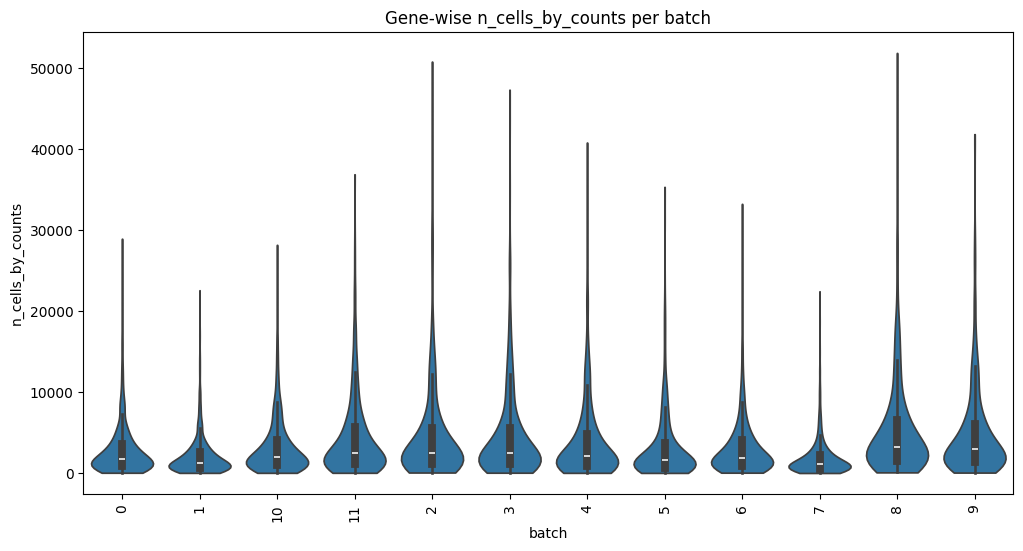

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.violinplot(
    data=df_long,
    x="batch",
    y="n_cells_by_counts",
    inner="box",   # 박스플롯 겸
    cut=0,
    scale="width"
)
plt.title("Gene-wise n_cells_by_counts per batch")
plt.xticks(rotation=90)
plt.show()


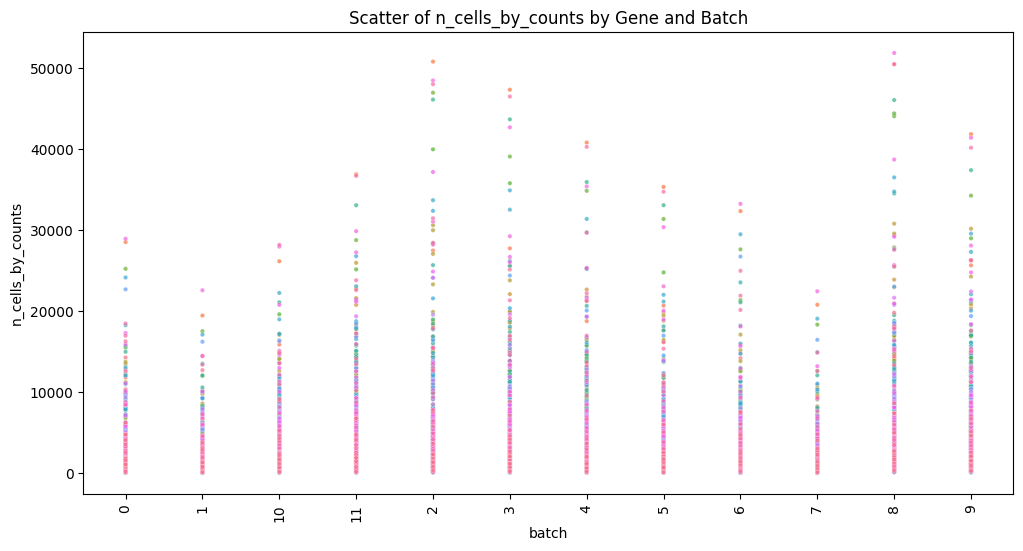

In [54]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df_long,
    x="batch",
    y="n_cells_by_counts",
    hue="gene",
    s=10,
    alpha=0.7,
    legend=False
)
plt.title("Scatter of n_cells_by_counts by Gene and Batch")
plt.xticks(rotation=90)
plt.show()


## plotting for cell-metadata

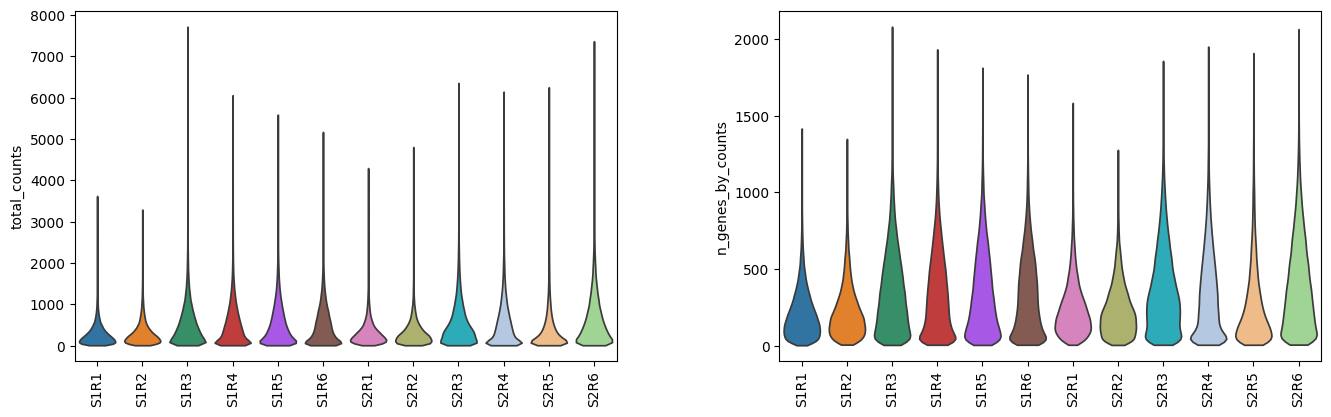

In [44]:
sc.pl.violin(
    crc,
    keys=["total_counts", "n_genes_by_counts"],
    groupby="batch",
    stripplot=False,  # 점 뿌리지 않고
    jitter=0.4,       # 살짝 퍼뜨리기
    rotation=90
)

# gene name 바꾸기

In [ ]:
# debugging for non shared gene problem

print("ST Data Gene Names (first 5):", st_data.var_names[:5].tolist())
print("SC Data Gene Names (first 5):", sc_data.var_names[:5].tolist())

print("\nST Data Number of Genes:", st_data.n_vars)
print("SC Data Number of Genes:", sc_data.n_vars)

In [ ]:
import scanpy as sc
import mygene
import pandas as pd
import numpy as np

# --- 1. 데이터 로드 (가정) ---
# sc_data = sc.read_h5ad("/path/to/your/scRNAseq_data.h5ad")
# st_data = sc.read_h5ad("/path/to/your/spatial_data.h5ad")

print("Original SC Data Gene Names (first 5):", sc_data.var_names[:5].tolist())
print(f"Original SC Data index is unique: {sc_data.var.index.is_unique}")

# --- 2. 원본 Ensembl ID 백업 및 버전 정보 제거 ---
sc_data.var['original_ensembl_id_with_version'] = sc_data.var_names # 원본 ID 백업

# 버전 정보 제거 (.숫자 제거)
sc_data.var['base_ensembl_id'] = sc_data.var_names.str.split('.').str[0]
print("Base Ensembl IDs (first 5):", sc_data.var['base_ensembl_id'][:5].tolist())

# --- 3. 고유한 Base Ensembl ID 목록 생성 ---
unique_base_ids = sc_data.var['base_ensembl_id'].unique().tolist()
print(f"Number of unique base Ensembl IDs to query: {len(unique_base_ids)}")

# --- 4. mygene을 사용하여 고유 ID 변환 ---
mg = mygene.MyGeneInfo()
print(f"Querying {len(unique_base_ids)} unique Ensembl IDs using mygene.info...")

gene_info = mg.querymany(unique_base_ids, scopes='ensembl.gene', fields='symbol', species='human', as_dataframe=True, returnall=True)

print("Query finished.")
# print(gene_info.head()) # 결과 확인용 (필요시 주석 해제)

# --- 5. Ensembl ID -> Symbol 매핑 사전 생성 ---
# 'out' 키 아래의 'symbol' 사용 및 NaN 값 제거
symbol_map = gene_info['out']['symbol'].dropna().to_dict()
print(f"Created map for {len(symbol_map)} Ensembl IDs to symbols.")

# --- 6. 결과를 sc_data.var에 매핑하여 'gene_symbol' 컬럼 생성 ---
# 'base_ensembl_id' 컬럼을 기준으로 symbol_map을 적용
sc_data.var['gene_symbol'] = sc_data.var['base_ensembl_id'].map(symbol_map)

# --- 7. 매핑 실패(NaN) 처리 ---
# 심볼을 찾지 못한 경우 (NaN): 'base_ensembl_id' 값을 사용
missing_symbols_mask = sc_data.var['gene_symbol'].isna()
n_missing = missing_symbols_mask.sum()
print(f"Number of genes with missing symbols (will use base Ensembl ID): {n_missing}")
if n_missing > 0:
    sc_data.var.loc[missing_symbols_mask, 'gene_symbol'] = sc_data.var.loc[missing_symbols_mask, 'base_ensembl_id']

# --- 8. sc_data의 var_names 업데이트 (Gene Symbol 사용 및 고유화) ---
print("Updating sc_data.var_names with gene symbols...")
# 새로운 유전자 심볼로 인덱스 업데이트 (문자열로 확실히 변환)
sc_data.var_names = sc_data.var['gene_symbol'].astype(str)

# 유전자 심볼 자체도 중복될 수 있으므로, 최종적으로 var_names를 고유하게 만듦
if not sc_data.var_names.is_unique:
    print("Duplicate gene symbols found. Making var_names unique...")
    sc_data.var_names_make_unique()
else:
    print("Gene symbols are unique.")


print("Updated SC Data Gene Names (first 5):", sc_data.var_names[:5].tolist())
print(f"Final SC Data index is unique: {sc_data.var.index.is_unique}")

# --- 9. 변환 후 공유 유전자 재확인 ---
shared_genes = st_data.var_names.intersection(sc_data.var_names)
print(f"\nNumber of shared genes after conversion: {len(shared_genes)}")

if len(shared_genes) > 0:
    print("First 5 shared genes:", shared_genes[:5].tolist())
    print("\nGene name conversion successful. You can now try initializing the ENVI model again.")
    # 이제 이 수정된 st_data와 sc_data를 사용하여 ENVI 모델 초기화를 다시 시도할 수 있습니다.
    # envi_model = scenvi.ENVI(spatial_data=st_data, sc_data=sc_data)
    # ...
else:
    print("\nWarning: Still no shared genes found after conversion. Please double-check gene symbol formats between datasets.")

## Save h5ad

In [ ]:
from datetime import datetime

# 현재 시각 가져오기
now = datetime.now()

# 원하는 형식으로 포맷팅: yy-mm-dd-hh-mm
formatted_time = now.strftime("%y-%m-%d-%H-%M")

print(formatted_time)

scre=sc_data
# 인덱스를 gene symbol로 업데이트
scre.var_names = scre.var['gene_symbol'].astype(str)

# gene_symbol 컬럼 삭제
scre.var.drop(columns=['gene_symbol'], inplace=True)

scre.write_h5ad('/data/kjc2/projects/P330.CSA/rds/downsampled_crc_after_gene_name_change'+formatted_time+'.h5ad')

In [ ]:
print(scre)

# scENVI

https://scenvi.readthedocs.io/en/latest/tutorial/MOp_MERFISH_tutorial.html#Importing

## data loading

In [4]:
sc_data=sc.read_h5ad("/data/kjc2/rds/downsampled.h5ad")
st_data=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/250210_CRC_BJM_0050585_Region1_25-04-14-16-53.h5ad")
# sc_data=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/downsampled_crc_after_gene_name_change25-04-14-23-04.h5ad")
sc_data=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/downsampled_100_25-04-15-08-34.h5ad")
print(sc_data)
print(st_data)

AnnData object with n_obs × n_vars = 426492 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_t

In [ ]:
print(sc_data)
print(st_data)

## downsampling

In [ ]:
sc_data_original=sc_data
st_data_original=st_data

sc.(sc_data

## model training

In [5]:
# We first define and ENVI model which computes the COVET matrices of the spatial data and intializes the CVAE:
# envi_model = scenvi.ENVI(spatial_data = adata, sc_data = crc_sc, covet_batch_size = 256)
envi_model = scenvi.ENVI(spatial_data = st_data, sc_data = sc_data,covet_batch_size=64)
# Training ENVI and run auxiliary function
envi_model.train()
envi_model.impute_genes()
envi_model.infer_niche_covet()
envi_model.infer_niche_celltype()

#Read ENVI predictions

st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']
st_data.obsm['cell_type_niche'] = envi_model.spatial_data.obsm['cell_type_niche']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.obsm['cell_type_niche'] = envi_model.sc_data.obsm['cell_type_niche']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

Preparing gene sets for ENVI analysis...
Using pre-computed highly variable genes from single-cell data
Gene selection: 0 shared genes, 7495 unique to single-cell


KeyboardInterrupt: 

In [ ]:
sc_data.uns['COVET_genes']

## model training

## Plot UMAPs of ENVI latent

In [ ]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.3,
    n_components = 2,
)

latent_umap = fit.fit_transform(np.concatenate([st_data.obsm['envi_latent'], sc_data.obsm['envi_latent']], axis = 0))

st_data.obsm['latent_umap'] = latent_umap[:st_data.shape[0]]
sc_data.obsm['latent_umap'] = latent_umap[st_data.shape[0]:]

# SpaGE